In [21]:
from datasets import load_dataset
import torch
import pandas as pd
import numpy as np

In [8]:
import pyarrow as pa

In [15]:
# Load the arrow file using pandas read_parquet since it's not an IPC file
file_path = "data-00000-of-00099.arrow"
dataset = pd.read_parquet(file_path)


In [16]:
# dataset = load_dataset("arrow", data_files=f"data-00000-of-00099.arrow")

In [24]:
emb = dataset["embedding"].to_numpy()


In [26]:
# Convert the 'emb' array to a numpy array of type float32 if it's not already
emb2 = np.array([np.array(e).astype(np.float32) for e in emb if e is not None])


In [28]:
torch.from_numpy(emb2).float()

tensor([[ 0.0167,  0.0739, -0.2085,  ..., -0.0752, -0.0378, -0.0068],
        [ 0.0267,  0.0170, -0.2101,  ..., -0.0763, -0.0599, -0.0577],
        [ 0.0088,  0.1048, -0.1803,  ..., -0.0804, -0.0415, -0.0508],
        ...,
        [-0.0144,  0.0734, -0.2041,  ..., -0.0232, -0.0118, -0.0566],
        [ 0.0132,  0.0963, -0.2029,  ..., -0.0338, -0.0073, -0.0279],
        [ 0.0342,  0.0775, -0.1728,  ..., -0.0356, -0.0131, -0.0317]])

In [29]:
df = pd.read_parquet("data-00000-of-00099.parquet")

In [30]:
df.head()

,chunk_index,chunk_text,chunk_tokens,chunk_token_count,id,url,score,dump,__index_level_0__,top_acts,top_indices
0,1,"health and safety laws must be complied with, ...","[2740, 1998, 3808, 4277, 2442, 2022, 26946, 20...",51,<urn:uuid:3c3b48b6-ae9c-4775-951d-069f26a9bfc3>,http://www.memetics.com/health-safety-in-the-w...,2.640625,CC-MAIN-2020-05,111784,"[0.0421563945710659, 0.029075803235173225, 0.0...","[1760.0, 2114.0, 2228.0, 2239.0, 2248.0, 2420...."
1,2,non - toxic gas. class or division ( subsidiar...,"[2512, 1011, 11704, 3806, 1012, 2465, 2030, 24...",51,<urn:uuid:c36e8c41-1f88-4187-86fd-05131180bb16>,https://pegaswitch.com/usefull-tips/what-is-pr...,2.609375,CC-MAIN-2023-14,115711,"[0.10615311563014984, 0.02909248322248459, 0.0...","[707.0, 1129.0, 2006.0, 2420.0, 2556.0, 2793.0..."
2,2,cookie is used to store your cookie preference...,"[17387, 2003, 2109, 2000, 3573, 2115, 17387, 1...",51,<urn:uuid:fe901b33-2818-48e6-98fc-47d752c0b8a5>,https://www.gunterprimary.org/online-safety/,3.203125,CC-MAIN-2023-14,256198,"[0.023492809385061264, 0.05083116888999939, 0....","[460.0, 570.0, 929.0, 1423.0, 1486.0, 1871.0, ..."
3,1,"for the essay were, how you have explored thes...","[2005, 1996, 9491, 2020, 1010, 2129, 2017, 203...",51,<urn:uuid:95c4c79d-3ea6-4819-9842-30bfdbd8f3dd>,http://heikewrites.com/critical-response-paper...,2.984375,CC-MAIN-2017-26,149277,"[0.021694719791412354, 0.017595764249563217, 0...","[438.0, 1862.0, 2059.0, 2228.0, 2775.0, 3023.0..."
4,2,giving up the centralised system. so unless mo...,"[3228, 2039, 1996, 2430, 5084, 2291, 1012, 206...",51,<urn:uuid:f4503818-7c41-4bea-a640-cbe6021693b9>,http://anar-kali.blogspot.com/2009/12/roots-of...,2.687500,CC-MAIN-2017-26,149295,"[0.03796019405126572, 0.046590086072683334, 0....","[1515.0, 1573.0, 2228.0, 2305.0, 2514.0, 2660...."


In [53]:
def get_top_n_rows_by_top_act(df, index, n=5):
    """
    Get the top N rows from the dataframe based on the top_act values for a given index in top_indices.

    Args:
    df (pd.DataFrame): DataFrame containing the columns 'top_acts' and 'top_indices'.
    index (int): The index to look for in the 'top_indices' list within each row.
    n (int): Number of top rows to return based on the highest 'top_act' values where the index is present.

    Returns:
    pd.DataFrame: A DataFrame containing the top N rows sorted by 'top_act' where the index is present.
    """
    # Filter rows where the index is present in the 'top_indices'
    filtered_df = df[df['top_indices'].apply(lambda indices: index in indices)]
    
    # Extract the corresponding 'top_act' for the given index
    
    def extract_act(row):
        if index not in row['top_indices']:
            return -1
        index_pos = np.where(row['top_indices'] == index)[0][0]
        return row['top_acts'][index_pos]
    
    # Apply the function to get the corresponding 'top_act'
    col = filtered_df.apply(extract_act, axis=1)
    # print("COL", col)
    filtered_df[f"act_for_{index}"] = col
    filtered_df = filtered_df[filtered_df[f"act_for_{index}"] >= 0]
    
    # Sort by 'act_for_index' and get the top N rows
    result_df = filtered_df.sort_values(by=f"act_for_{index}", ascending=False).head(n)
    
    # Drop the temporary column before returning
    # result_df = result_df.drop(columns=[f"act_for_{index}"])
    
    return result_df

# Example usage:
# top_rows = get_top_n_rows_by_top_act(df, index=707, n=10)
# print(top_rows)


In [58]:
top_rows = get_top_n_rows_by_top_act(df, index=24000, n=10)

/var/folders/sx/rrvr6l_d5x1_g46jxlx5ypfc0000gn/T/ipykernel_46015/4072508244.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[f"act_for_{index}"] = col


In [59]:
top_rows

,chunk_index,chunk_text,chunk_tokens,chunk_token_count,id,url,score,dump,__index_level_0__,top_acts,top_indices,act_for_24000
193018,2,into abeyance! so much is getting abolished ; ...,"[2046, 14863, 7054, 3401, 999, 2061, 2172, 200...",500,<urn:uuid:7a22f45d-3805-411b-b13c-32b53c51125f>,http://www.fullbooks.com/The-French-Revolution...,2.515625,CC-MAIN-2013-20,197587,"[0.02789011225104332, 0.024830246344208717, 0....","[1144.0, 1183.0, 2228.0, 2271.0, 2287.0, 2660....",0.042769
17399,3,keep your glasses on painlessly ( letter ) ; p...,"[2562, 2115, 7877, 2006, 3255, 10895, 1006, 36...",137,<urn:uuid:294bb17a-1538-4832-b9eb-c7f1c5cde672>,http://rlbatesmd.blogspot.com/2008/09/surgical...,2.718750,CC-MAIN-2013-20,131743,"[0.027690093964338303, 0.055266641080379486, 0...","[0.0, 298.0, 692.0, 1089.0, 1129.0, 1144.0, 13...",0.042720
208462,2,"rolled back, and looking down the alley of mar...","[4565, 2067, 1010, 1998, 2559, 2091, 1996, 897...",500,<urn:uuid:5d4ffad8-6142-4688-b541-3c01a8389cdf>,https://www.leonaur.com/index.php?route=produc...,3.078125,CC-MAIN-2017-26,213045,"[0.024910559877753258, 0.02349037490785122, 0....","[996.0, 1136.0, 1140.0, 1300.0, 2191.0, 2228.0...",0.042651
63218,0,"If you go into the centre of Sydney today, you...","[101, 2065, 2017, 2175, 2046, 1996, 2803, 1997...",325,<urn:uuid:7587ccf6-fc42-4576-b3d1-1b37eb4d887c>,https://scratchingsydneyssurface.wordpress.com...,2.625000,CC-MAIN-2017-26,81206,"[0.2043761909008026, 0.023110954090952873, 0.0...","[1221.0, 1504.0, 1983.0, 2006.0, 2287.0, 2305....",0.041134
25427,3,all the restriction and the delays. ” there is...,"[2035, 1996, 16840, 1998, 1996, 14350, 1012, 1...",170,<urn:uuid:1304f5b0-7945-4bd9-9b75-eb35b04024fe>,https://www.texasobserver.org/as-seas-rise-tex...,2.625000,CC-MAIN-2020-05,43448,"[0.028289951384067535, 0.039388127624988556, 0...","[376.0, 1536.0, 2228.0, 2945.0, 3195.0, 3718.0...",0.040764
232665,2,"1949, there were mellick stores in townsville,...","[4085, 1010, 2045, 2020, 11463, 25230, 5324, 1...",500,<urn:uuid:9bdc67ce-b528-4c1f-ac67-19aab02c7076>,http://alhs.org.au/?p=1025,2.953125,CC-MAIN-2020-05,237248,"[0.021525757387280464, 0.067937932908535, 0.02...","[110.0, 698.0, 1006.0, 1126.0, 1221.0, 1293.0,...",0.040587
117200,0,"[CLS] for centuries, lacquer finishes have bee...","[101, 2005, 4693, 1010, 18749, 4226, 2099, 123...",500,<urn:uuid:a4bf5423-d3c2-4a68-8b0b-26d44bea3301>,https://www.woodworkweb.com/woodworking-videos...,2.593750,CC-MAIN-2023-14,121786,"[0.02717817947268486, 0.02635219320654869, 0.1...","[544.0, 1180.0, 1403.0, 2006.0, 2305.0, 3386.0...",0.039827
210704,7,one between the two eastern columns of the cen...,"[2028, 2090, 1996, 2048, 2789, 7753, 1997, 199...",500,<urn:uuid:0acc27b9-8ea8-4434-b9b7-31b0f52964d0>,http://www.british-history.ac.uk/vch/hants/vol...,2.718750,CC-MAIN-2017-26,215294,"[0.05348293110728264, 0.05246329680085182, 0.0...","[322.0, 461.0, 1712.0, 1889.0, 2041.0, 2399.0,...",0.039785
12656,1,1870 - 1885 ( http : / / memory. loc. gov / am...,"[6940, 1011, 6571, 1006, 8299, 1024, 1013, 101...",116,<urn:uuid:2d15d6ea-febc-41bb-b37c-511f16f51f12>,http://digicoll.library.wisc.edu/MillsSpColl/s...,2.656250,CC-MAIN-2013-20,135858,"[0.024801600724458694, 0.18291889131069183, 0....","[119.0, 350.0, 832.0, 1325.0, 1365.0, 1590.0, ...",0.039554
97397,0,|Overview: Switching Barriers|\n|Definition||A...,"[101, 1064, 19184, 1024, 11991, 13500, 1064, 1...",499,<urn:uuid:8a1c0652-3b21-4e6a-bf87-e1b2e487f1af>,https://simplicable.com/economics/switching-ba...,2.968750,CC-MAIN-2023-14,191126,"[0.0660753846168518, 0.02723151072859764, 0.03...","[793.0, 843.0, 1120.0, 1129.0, 1750.0, 1760.0,...",0.038845


In [67]:
# tdf = pd.read_parquet("top10-data-00001-of-00099.parquet")
tdf = pd.read_parquet("top10-data-00000-of-00099.parquet")

In [68]:
tdf.head()

,chunk_index,chunk_text,chunk_tokens,chunk_token_count,id,url,score,dump,__index_level_0__,top_acts,...,act_for_23030,act_for_23031,act_for_23032,act_for_23033,act_for_23034,act_for_23035,act_for_23036,act_for_23037,act_for_23038,act_for_23039
0,0,[CLS] wire in composite wire in composite wire...,"[101, 7318, 1999, 12490, 7318, 1999, 12490, 73...",500,<urn:uuid:2fe8cc05-9747-4dce-8e36-a25027706949>,http://www.bf1systems.com/product/wire-in-comp...,3.031250,CC-MAIN-2017-26,157308,"[0.03511637821793556, 0.01979164034128189, 0.0...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,"[CLS] in scriptwriting, a composite is a chara...","[101, 1999, 5896, 18560, 1010, 1037, 12490, 20...",500,<urn:uuid:e686658c-ea44-4841-8a1e-244af04693b4>,https://videocide.com/glossary/composite-chara...,3.359375,CC-MAIN-2020-05,110120,"[0.021567920222878456, 0.030998528003692627, 0...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,"[CLS] ann, while the application of composites...","[101, 5754, 1010, 2096, 1996, 4646, 1997, 1249...",500,<urn:uuid:1943c136-4969-4a0b-824d-dc504f28e829>,http://www.designnews.com/messages.asp?piddl_m...,2.828125,CC-MAIN-2013-20,72647,"[0.041676126420497894, 0.0425071120262146, 0.0...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,"composites science and technology, vol. l64, n...","[12490, 2015, 2671, 1998, 2974, 1010, 5285, 10...",500,<urn:uuid:b790259f-2b3e-4bc1-88fc-d51966fe8b73>,https://m.scirp.org/papers/17042,2.562500,CC-MAIN-2020-05,35681,"[0.022060487419366837, 0.023509465157985687, 0...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Composite piezoelectric ceramics are important...,"[101, 12490, 11345, 6844, 12260, 22601, 17314,...",303,<urn:uuid:4240098b-dbdb-46b5-8027-5ac6f6ca9473>,https://www.ias.ac.in/describe/article/boms/03...,2.609375,CC-MAIN-2020-05,238381,"[0.041422288864851, 0.030768919736146927, 0.02...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
tdf["feature"]

0         20736.0
1         20736.0
2         20736.0
3         20736.0
4         20736.0
           ...   
220293    23039.0
220294    23039.0
220295    23039.0
220296    23039.0
220297    23039.0
Name: feature, Length: 220298, dtype: float64

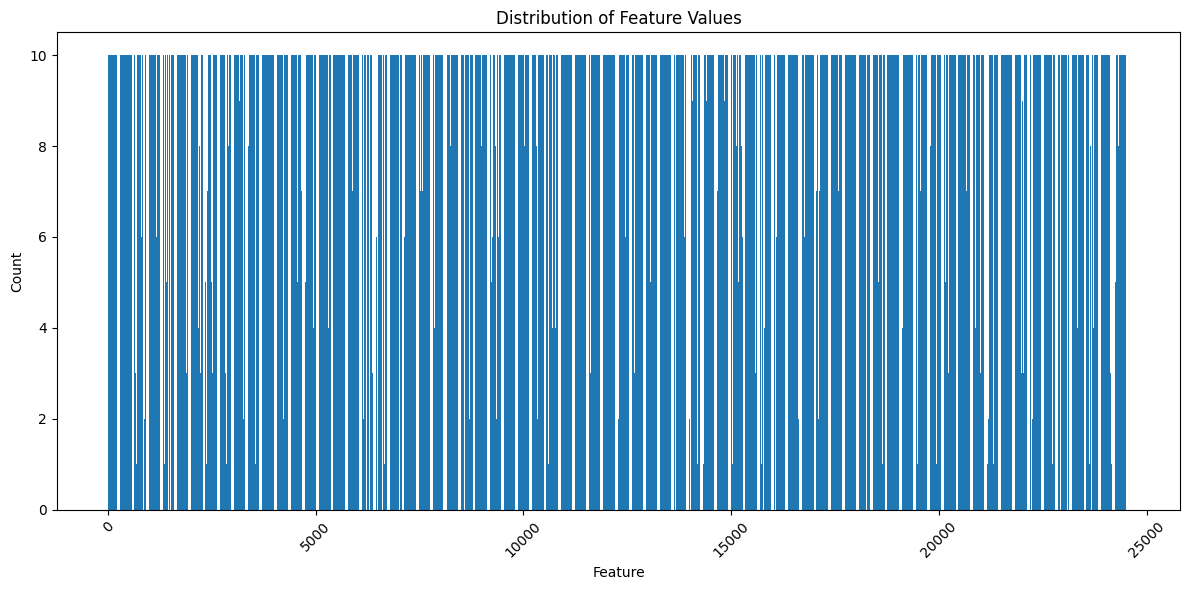

Total unique features: 23877


In [70]:
# Get the distribution of feature values
feature_distribution = tdf["feature"].value_counts().sort_index()

# Plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(feature_distribution.index, feature_distribution.values)
plt.xlabel('Feature')
plt.ylabel('Count')
plt.title('Distribution of Feature Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print some statistics
print("Total unique features:", len(feature_distribution))


In [102]:
top_indices = np.array(tdf["top_indices"].tolist())
top_acts = np.array(tdf["top_acts"].tolist())

In [103]:
top_indices

array([[  120.,   188.,   428., ..., 23693., 24319.,  4167.],
       [  710.,  1343.,  1388., ..., 23959., 24319., 11439.],
       [ 1144.,  1746.,  2009., ..., 23839., 24008.,  7231.],
       ...,
       [  120.,   363.,   562., ..., 23548., 24077.,  9867.],
       [  188.,   279.,   719., ..., 24008., 24085., 19866.],
       [   76.,   150.,   188., ..., 23548., 23642., 14770.]])

In [121]:
top_indices.shape

(220298, 64)

In [108]:
index = 0

In [117]:
# index_positions = (top_indices == 20).argmax(axis=1)
# Calculate index_positions with -1 for values not in top_indices
index_positions = np.where(np.any(top_indices == index, axis=1),
                           np.argmax(top_indices == index, axis=1),
                           -1)


In [118]:
# Get the activation values for the index_positions
act_values = np.where(index_positions != -1, 
                      top_acts[np.arange(len(top_acts)), index_positions], 
                      0)

# Print some statistics about the activation values
print("Number of non-zero activations:", np.count_nonzero(act_values))
print("Mean activation value:", np.mean(act_values[act_values > 0]))
print("Max activation value:", np.max(act_values))
print("Min non-zero activation value:", np.min(act_values[act_values > 0]))

# Optionally, you can add the activation values to the tdf DataFrame
# tdf[f'activation_for_index_{index}'] = act_values


Number of non-zero activations: 847
Mean activation value: 0.04136160211780558
Max activation value: 0.16033005714416504
Min non-zero activation value: 0.012763936072587967


In [119]:
# Get the indices of the top 5 activations in act_values
top_5_indices = np.argsort(act_values)[-5:][::-1]

# Print the top 5 indices and their corresponding activation values
print("Top 5 indices and their activation values:")
for idx in top_5_indices:
    print(f"Index: {idx}, Activation: {act_values[idx]}")

# Get the corresponding index_positions for the top 5 activations
top_5_index_positions = index_positions[top_5_indices]

print("\nCorresponding index_positions for top 5 activations:")
print(top_5_index_positions)


Top 5 indices and their activation values:
Index: 61952, Activation: 0.16033005714416504
Index: 85933, Activation: 0.16033005714416504
Index: 52372, Activation: 0.16033005714416504
Index: 52373, Activation: 0.14998489618301392
Index: 61953, Activation: 0.14998489618301392

Corresponding index_positions for top 5 activations:
[0 0 0 0 0]


In [120]:
len(index_positions)

220298

In [113]:
# Get non-zero values of index_positions
nonzero_positions = index_positions[index_positions >= 0]

# Print the result
print(nonzero_positions)
print(len(nonzero_positions))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 63  0  0  0  0  0  0  0  0  0  0  0  0  0 63  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 63  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 63
  0  0  0  0  0  0  0  0  0  0  0  0  0 63  0  0  0

In [115]:
# Filter tdf to rows where index_positions are 0 or more
filtered_tdf = tdf.loc[top_5_indices]

# Print the shape of the filtered DataFrame to verify the result
print("Shape of filtered DataFrame:", filtered_tdf.shape)

# Optionally, display the first few rows of the filtered DataFrame
print("\nFirst few rows of filtered DataFrame:")
print(filtered_tdf.head())


Shape of filtered DataFrame: (5, 23890)

First few rows of filtered DataFrame:
       chunk_index                                         chunk_text  \
61952            0  Gelatin printing is a form of monoprinting in ...   
85933            0  Gelatin printing is a form of monoprinting in ...   
52372            0  Gelatin printing is a form of monoprinting in ...   
52373            2  measured their blood and urine. from their gra...   
61953            2  measured their blood and urine. from their gra...   

                                            chunk_tokens  chunk_token_count  \
61952  [101, 21500, 20363, 8021, 2003, 1037, 2433, 19...                173   
85933  [101, 21500, 20363, 8021, 2003, 1037, 2433, 19...                173   
52372  [101, 21500, 20363, 8021, 2003, 1037, 2433, 19...                173   
52373  [7594, 2037, 2668, 1998, 17996, 1012, 2013, 20...                500   
61953  [7594, 2037, 2668, 1998, 17996, 1012, 2013, 20...                500   

       

In [116]:
filtered_tdf["feature"]

61952       0.0
85933    1884.0
52372    5826.0
52373    5826.0
61953       0.0
Name: feature, dtype: float64